# 1. Processing Machine events and task events data for data preparation

In [170]:
import pandas as pd

# Load the gzipped CSV file
# df = pd.read_csv("./task_events/task_events/part-*-of-00500.csv.gz", header=None)
df = pd.read_csv("./task_events/task_events/part-00000-of-00500.csv.gz", header=None)

# Assign column names based on the schema
df.columns = [
    "timestamp", "missing_info", "job_ID", "task_index", "machine_ID", 
    "event_type", "user_name", "scheduling_class", "priority", 
    "cpu_request", "memory_request", "resource_request_disk", 
    "different_machine_constraint"
]

# Select specific columns for further analysis
df = df[["timestamp", "job_ID", "task_index", "event_type", "cpu_request", "memory_request"]]

# Display the first 5 rows
print(df.head(5))
print()

# Read the CSV file
df1 = pd.read_csv("./machine_events/machine_events/part-00000-of-00001.csv.gz", header=None)

# Rename columns
df1.columns = ["timestamp", "machine_ID", "event_type", "platform_ID", "capacity_CPU", "capacity_memory"]

# Select specific columns
df1 = df1[["timestamp", "machine_ID", "event_type", "capacity_CPU", "capacity_memory"]]

# Display the first 5 rows of the dataframe
print(df1.head(5))

   timestamp   job_ID  task_index  event_type  cpu_request  memory_request
0          0  3418309           0           0          NaN             NaN
1          0  3418309           1           0          NaN             NaN
2          0  3418314           0           0        0.125         0.07446
3          0  3418314           1           0        0.125         0.07446
4          0  3418319           0           0          NaN             NaN

   timestamp  machine_ID  event_type  capacity_CPU  capacity_memory
0          0           5           0           0.5           0.2493
1          0           6           0           0.5           0.2493
2          0           7           0           0.5           0.2493
3          0          10           0           0.5           0.2493
4          0          13           0           0.5           0.2493


# Retrieving Task Runtimes

To retrieve task runtime:
    1. Idenitfy submissions and completetions of each job, removing duplicate entries
    2. Calculate the duration between the submission and completion timestamps to determine how long each job ran

Note:
For each job id, the runtime is the timestamp of event type = 4 (finished) - event type = 0 (submitted)
Also, since timestamp is in millisecond, get the runtime in seconds (round off)
Laslt, only store tasks with both finished and submitted ids with their actual runtimes.

In [171]:
import pandas as pd
import glob

def calculate_task_runtimes(file_pattern='./task_events/task_events/part-00000-of-00500.csv.gz'):
    """
    Calculate task runtimes from Google cluster data by finding the duration between
    submission (event_type=0) and completion (event_type=4) events. Include CPU and memory requests.
    
    Args:
        file_pattern: Glob pattern for task event files
        
    Returns:
        DataFrame with task details including job_ID, task_index, CPU/memory requests, 
        timestamps, and runtime in seconds
    """
    # Initialize empty list to store all relevant events
    all_events = []

    # Process each file matching the pattern
    for filename in glob.glob(file_pattern):
        # Read the gzipped CSV
        df = pd.read_csv(filename, header=None)
        
        # Assign column names
        df.columns = [
            "timestamp", "missing_info", "job_ID", "task_index", "machine_ID", 
            "event_type", "user_name", "scheduling_class", "priority", 
            "cpu_request", "memory_request", "resource_request_disk", 
            "different_machine_constraint"
        ]

        # Remove rows with timestamp 0 as they are invalid due to occuring before the trace
        df = df[df["timestamp"] != 0]

        # Convert timestamp from microseconds to seconds and round
        df["timestamp"] = (df["timestamp"] / 1_000_000).round()
        
        # Select only needed columns and relevant events (0=submit, 4=finish)
        events = df[[
            "timestamp", "job_ID", "task_index", "event_type", 
            "cpu_request", "memory_request"
        ]]
        events = events[events["event_type"].isin([0, 4])]
        
        all_events.append(events)
    
    # Combine all events
    combined_events = pd.concat(all_events, ignore_index=True)
    
    # Calculate the maximum timestamp
    maximumStamp = combined_events["timestamp"].max()
    
    # Create a unique task identifier
    combined_events['task_id'] = combined_events['job_ID'].astype(str) + '_' + combined_events['task_index'].astype(str)
    
    # Get submit events
    submits = combined_events[combined_events['event_type'] == 0].drop_duplicates('task_id')
    
    # Get finish events
    finishes = combined_events[combined_events['event_type'] == 4].drop_duplicates('task_id')
    
    # Merge submit and finish events
    task_runtimes = pd.merge(
        submits[['task_id', 'timestamp', 'cpu_request', 'memory_request']],
        finishes[['task_id', 'timestamp']],
        on='task_id',
        suffixes=('_submit', '_finish')
    )
    
    # Calculate runtime in seconds (rounding to nearest second)
    task_runtimes['runtime'] = (task_runtimes['timestamp_finish'] - task_runtimes['timestamp_submit']).round()
    
    # Split task_id back into job_ID and task_index
    task_runtimes[['job_ID', 'task_index']] = task_runtimes['task_id'].str.split('_', expand=True)
    
    # Select and order final columns
    final_runtimes = task_runtimes[[
        'job_ID', 'task_index', 'cpu_request', 'memory_request', 
        'timestamp_submit', 'runtime'
    ]].rename(columns={'timestamp_submit': 'timestamp', 'cpu_request': 'CPU_request'})
    
    # Convert job_ID and task_index back to original types
    final_runtimes['job_ID'] = final_runtimes['job_ID'].astype(int)
    final_runtimes['task_index'] = final_runtimes['task_index'].astype(int)
    
    return final_runtimes, maximumStamp

# Example usage
task_runtimes, maximumStamp = calculate_task_runtimes()

task_runtimes = task_runtimes.dropna(subset=['task_index', 'CPU_request', 'memory_request', 'timestamp', 'runtime'])


print(f"Maximum timestamp: {maximumStamp}")
print(f"Found {len(task_runtimes)} tasks with complete runtime data")
print("\nSample of task runtimes:")
print(task_runtimes.head())



Maximum timestamp: 5611.0
Found 38362 tasks with complete runtime data

Sample of task runtimes:
       job_ID  task_index  CPU_request  memory_request  timestamp  runtime
0  6250345153         878      0.06873        0.011930      604.0   2368.0
1  6251639646           0      0.06250        0.015900      604.0     71.0
2  6251668759           0      0.06250        0.004662      612.0     50.0
3  6250345153         822      0.06873        0.011930      614.0   2155.0
4  6251668917           0      0.03125        0.015900      617.0     36.0


# Retrieving Available Instance Types and Their Prices

In [172]:
import pandas as pd
import numpy as np

def get_instance_types_and_prices(machine_events_file='./machine_events/machine_events/part-00000-of-00001.csv.gz'):
    """
    Extract unique instance types from machine events and calculate their normalized prices
    based on GCP pricing ($0.03899 per CPU hour and $0.005226 per GB hour).
    
    Args:
        machine_events_file: Path to machine events file
        
    Returns:
        DataFrame with unique instance types and their normalized prices
    """
    # Read machine events
    df = pd.read_csv(machine_events_file, header=None)
    df.columns = ["timestamp", "machine_ID", "event_type", "platform_ID", "capacity_CPU", "capacity_memory"]
    
    # Filter for timestamp 0 and get unique combinations of CPU and memory
    instance_types = df[df['timestamp'] == 0][['capacity_CPU', 'capacity_memory']].drop_duplicates()
    
    # GCP pricing constants (per hour)
    CPU_PRICE_PER_HOUR = 0.03899
    MEMORY_PRICE_PER_GB_HOUR = 0.005226
    
    def calculate_price(row):
        """Calculate price based on CPU and memory capacity"""
        cpu_cost = row['capacity_CPU'] * CPU_PRICE_PER_HOUR
        memory_cost = row['capacity_memory'] * MEMORY_PRICE_PER_GB_HOUR
        return cpu_cost + memory_cost
    
    # Calculate raw prices
    instance_types['price'] = instance_types.apply(calculate_price, axis=1)
    
    # Normalize prices (divide by maximum price)
    instance_types['normalized_price'] = instance_types['price'] / instance_types['price'].max()
    
    # Sort by CPU capacity and memory capacity
    instance_types_sorted = instance_types.sort_values(['capacity_CPU', 'capacity_memory'])
    
    # Reset index and create instance type ID
    instance_types_final = instance_types_sorted.reset_index(drop=True)
    instance_types_final.index += 1  # Start index at 1
    
    # Round numbers for better readability
    instance_types_final['capacity_CPU'] = instance_types_final['capacity_CPU'].round(5)
    instance_types_final['capacity_memory'] = instance_types_final['capacity_memory'].round(5)
    instance_types_final['normalized_price'] = instance_types_final['normalized_price'].round(6)
    
    # Keep only necessary columns
    final_df = instance_types_final[['capacity_CPU', 'capacity_memory', 'normalized_price']]
    
    return final_df

# Example usage
instance_types = get_instance_types_and_prices()
sorted_instance_types = instance_types.sort_values(
    by=["capacity_CPU", "capacity_memory"], ascending=[False, False]
)
instance_types = sorted_instance_types
print("Available Instance Types and Their Normalized Prices:")
print("=" * 60)
print(instance_types)

Available Instance Types and Their Normalized Prices:
    capacity_CPU  capacity_memory  normalized_price
10          1.00          1.00000          1.000000
9           1.00          0.50000          0.940904
8           0.50          0.96780          0.555290
7           0.50          0.74900          0.529430
6           0.50          0.49950          0.499941
5           0.50          0.24930          0.470369
4           0.50          0.12410          0.455571
3           0.50          0.06158          0.448182
2           0.50          0.03085          0.444550
1           0.25          0.24980          0.249976


# Stratus Implementation

In [173]:
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple

class StratusScheduler:
    def __init__(self, available_instance_types: pd.DataFrame):
        """
        Initialize the Stratus scheduler
        
        Args:
            available_instance_types: DataFrame with columns ['capacity_CPU', 'capacity_memory', 'normalized_price']
            task_runtimes: DataFrame with columns ['job_ID', 'task_index', 'runtime_seconds']
        """
        self.available_instance_types = available_instance_types

        self.max_cpu = self.available_instance_types['capacity_CPU'].max()
        self.max_memory = self.available_instance_types['capacity_memory'].max()
        
        # Initialize empty task bins and instance bins
        self.task_bins = pd.DataFrame(columns=[
            'job_ID', 
            'task_index',
            'bin_index',
            'instance_ID',
            'CPU_request',
            'memory_request', 
            'timestamp',
            'runtime'
        ])
        
        self.instance_bins = pd.DataFrame(columns=[
            'instance_ID',
            'bin_index',
            'CPU_capacity',
            'CPU_used',
            'memory_capacity', 
            'memory_used',
            'timestamp',
            'runtime',
            'price'
        ])
        
        self.instance_counter = 0
        self.price_counter = 0
        self.tasks = 0
        self.cpu_utilization = 0.0  # Percentage of CPU resources used across all instances
        self.memory_utilization = 0.0  # Percentage of memory resources used across all instances

    
    # Frees tasks and instances at current timestamps
    def free_tasks_and_instances(self, current_timestamp):
        #free expired tasks
        expired_tasks = self.task_bins[self.task_bins['timestamp'] + self.task_bins['runtime'] <= current_timestamp]
        for _, task in expired_tasks.iterrows():
            instance_id = task['instance_ID']
            self.instance_bins.loc[self.instance_bins['instance_ID'] == instance_id, 'CPU_used'] -= task['CPU_request']
            self.instance_bins.loc[self.instance_bins['instance_ID'] == instance_id, 'memory_used'] -= task['memory_request']
        self.task_bins = self.task_bins[~self.task_bins.index.isin(expired_tasks.index)]

        #free expired instances
        expired_instances = self.instance_bins[self.instance_bins['timestamp'] + self.instance_bins['runtime'] <= current_timestamp]
        self.instance_bins = self.instance_bins[~self.instance_bins.index.isin(expired_instances.index)]

        # Update utilization metrics
        total_cpu_capacity = self.instance_bins['CPU_capacity'].sum()
        total_memory_capacity = self.instance_bins['memory_capacity'].sum()
        total_cpu_used = self.instance_bins['CPU_used'].sum()
        total_memory_used = self.instance_bins['memory_used'].sum()

        self.cpu_utilization = (total_cpu_used / total_cpu_capacity) * 100 if total_cpu_capacity > 0 else 0
        self.memory_utilization = (total_memory_used / total_memory_capacity) * 100 if total_memory_capacity > 0 else 0

    # Simple implementation of runtime binning    
    def _calculate_bin_index(self, runtime: float) -> int:
        """Calculate bin index based on runtime using exponential binning"""
        if runtime <= 0:
            return 0
        return int(np.floor(np.log2(runtime))) + 1
    
    def _get_instance_with_most_resources(self, eligible_instances: pd.DataFrame) -> pd.Series:
        # Calculate the available CPU and memory for each instance
        # eligible_instances['available_resources'] = (
        #     (eligible_instances['CPU_capacity'] - eligible_instances['CPU_used']) +
        #     (eligible_instances['memory_capacity'] - eligible_instances['memory_used'])
        # )

        eligible_instances = eligible_instances.copy()
        eligible_instances['available_resources'] = (
            (eligible_instances['CPU_capacity'] - eligible_instances['CPU_used']) +
            (eligible_instances['memory_capacity'] - eligible_instances['memory_used'])
        )

        # Find the instance with the highest available resources
        best_instance_index = eligible_instances['available_resources'].idxmax()

        # Return the instance as a Series
        return eligible_instances.loc[best_instance_index]
    
    def _promote_instance(self, instance: pd.Series, new_bin_index: int, current_timestamp):
        # Find the index of the instance in the instance_bins DataFrame
        instance_idx = self.instance_bins.index[
            self.instance_bins['instance_ID'] == instance['instance_ID']
        ][0]
        
        # Update the instance's bin index to the new bin index
        self.instance_bins.at[instance_idx, 'bin_index'] = new_bin_index

    
    def packer(self, new_tasks: pd.DataFrame):
        """
        Pack new tasks onto existing instances
        
        Args:
            new_tasks: DataFrame with task information
            
        Returns:
            List of unscheduled tasks
        """
        # Sort tasks by runtime descending
        sorted_tasks = new_tasks.sort_values('runtime', ascending=False)
        unscheduled_tasks = []
        
        for _, task in sorted_tasks.iterrows():
            task_bin = self._calculate_bin_index(task['runtime'])
            
            # Up-packing phase
            # Try same bin first
            same_bin_instances = self.instance_bins[
                self.instance_bins['bin_index'] == task_bin
            ]
            
            eligible_instances = same_bin_instances[
                (same_bin_instances['CPU_capacity'] - same_bin_instances['CPU_used'] >= task['CPU_request']) &
                (same_bin_instances['memory_capacity'] - same_bin_instances['memory_used'] >= task['memory_request'])
            ]
        
            # If there are elgibile instances with the same bin, assign to instance with closest remaining runtime
            if not eligible_instances.empty:

                remaining_runtime = eligible_instances['runtime'] - (
                    task['timestamp'] - eligible_instances['timestamp']
                )
                runtime_diff = abs(remaining_runtime - task['runtime'])
                # print("Eligible Instances:\n", eligible_instances)
                # print("Runtime Diff:\n", runtime_diff)
                # if runtime_diff.idxmin() not in eligible_instances.index:
                #     print("Invalid index from runtime_diff.idxmin()")
                instance = eligible_instances.loc[runtime_diff.idxmin()]

                self._assign_task_to_instance(task, instance)
                continue

                
            # Try higher bins
            higher_bin_instances = self.instance_bins[
                self.instance_bins['bin_index'] > task_bin
            ]

            eligible_instances = higher_bin_instances[
                (higher_bin_instances['CPU_capacity'] - higher_bin_instances['CPU_used'] >= task['CPU_request']) &
                (higher_bin_instances['memory_capacity'] - higher_bin_instances['memory_used'] >= task['memory_request'])
            ]
            
            if not eligible_instances.empty:
                # Assign to instance with most available resources
                instance = self._get_instance_with_most_resources(eligible_instances)
                self._assign_task_to_instance(task, instance)
                continue
                
            # Down-packing phase
            lower_bin_instances = self.instance_bins[
                self.instance_bins['bin_index'] < task_bin
            ]

            eligible_instances = lower_bin_instances[
                (lower_bin_instances['CPU_capacity'] - lower_bin_instances['CPU_used'] >= task['CPU_request']) &
                (lower_bin_instances['memory_capacity'] - lower_bin_instances['memory_used'] >= task['memory_request'])
            ]
            
            if not eligible_instances.empty:
                # Promote instance and assign task
                instance = self._get_instance_with_most_resources(eligible_instances)
                self._promote_instance(instance, task_bin, task['timestamp'])
                self._assign_task_to_instance(task, instance)
                continue
                
            unscheduled_tasks.append(task)
            
        self.scaler(unscheduled_tasks)

        

    def scaler(self, unscheduled_tasks: List[pd.Series]):
        """
        Scale out by acquiring new instances for unscheduled tasks
        
        Args:
            unscheduled_tasks: List of tasks that couldn't be packed
        """
        # Group tasks by bin
        tasks_by_bin = {}
        for task in unscheduled_tasks:
            bin_idx = self._calculate_bin_index(task['runtime'])
            if bin_idx not in tasks_by_bin:
                tasks_by_bin[bin_idx] = []
            tasks_by_bin[bin_idx].append(task)
            
        # Process bins in descending order
        for bin_idx in sorted(tasks_by_bin.keys(), reverse=True):
            bin_tasks = tasks_by_bin[bin_idx]

            # Sort tasks by descending resource requirements (e.g., CPU or memory)
            bin_tasks.sort(key=lambda task: max(task['CPU_request'], task['memory_request']), reverse=True)
            
            while bin_tasks:
                # Create candidate groups
                best_score = -1
                best_instance_type = None
                best_group_size = 0
                
                for i in range(1, len(bin_tasks) + 1):
                    candidate_group = bin_tasks[:i]
                    
                    # Try each instance type
                    for _, instance_type in self.available_instance_types.iterrows():
                        if self._can_fit_group(candidate_group, instance_type):
                            score = self._calculate_score(candidate_group, instance_type)
                            if score > best_score:
                                best_score = score
                                best_instance_type = instance_type
                                best_group_size = i
                
                if best_instance_type is not None:
                    # Acquire new instance and assign tasks
                    instance = self._acquire_new_instance(best_instance_type, bin_idx)
                    for task in bin_tasks[:best_group_size]:
                        self._assign_task_to_instance(task, instance)
                    bin_tasks = bin_tasks[best_group_size:]
                else:
                    # Couldn't find suitable instance type
                    break
                    
    def _assign_task_to_instance(self, task: pd.Series, instance: pd.Series):
        """Assign a task to an instance and update relevant metrics"""
        # Update instance resources

        # Ensure the instance exists
        # matching_indices = self.instance_bins.index[
        #     self.instance_bins['instance_ID'] == instance['instance_ID']
        # ]

        instance_idx = self.instance_bins.index[
            self.instance_bins['instance_ID'] == instance['instance_ID']
            ][0]
        
        self.instance_bins.at[instance_idx, 'CPU_used'] += task['CPU_request']
        self.instance_bins.at[instance_idx, 'memory_used'] += task['memory_request']

        # Update utilization metrics
        total_cpu_capacity = self.instance_bins['CPU_capacity'].sum()
        total_memory_capacity = self.instance_bins['memory_capacity'].sum()
        total_cpu_used = self.instance_bins['CPU_used'].sum()
        total_memory_used = self.instance_bins['memory_used'].sum()

        self.cpu_utilization = (total_cpu_used / total_cpu_capacity) * 100 if total_cpu_capacity > 0 else 0
        self.memory_utilization = (total_memory_used / total_memory_capacity) * 100 if total_memory_capacity > 0 else 0

        # try:
        #     if matching_indices.empty:
        #         raise ValueError(f"Instance ID {instance['instance_ID']} not found in instance_bins.")
        #     instance_idx = matching_indices[0]
        # except ValueError as e:
        #     print(f"Error: {e}")
        #     # Optionally log the error or handle it gracefully
        #     return  # Or take other appropriate action

        # Update instance details as required
        if self.instance_bins.at[instance_idx, 'runtime'] == 0: 
            self.instance_bins.at[instance_idx, 'timestamp'] = task['timestamp']
            self.instance_bins.at[instance_idx, 'runtime'] = task['runtime']
            self.price_counter += self.instance_bins.at[instance_idx, 'price'] * task['runtime']
        else:
            max_timestamp = max(
                task['runtime'] + task['timestamp'], 
                self.instance_bins.at[instance_idx, 'runtime'] + self.instance_bins.at[instance_idx, 'timestamp']
            )
            additional_runtime = task['runtime'] + task['timestamp'] - self.instance_bins.at[instance_idx, 'runtime'] + self.instance_bins.at[instance_idx, 'timestamp']
            self.instance_bins.at[instance_idx, 'timestamp'] = task['timestamp']
            self.instance_bins.at[instance_idx, 'runtime'] = max_timestamp - task['timestamp']
            if additional_runtime > 0:
                self.price_counter += self.instance_bins.at[instance_idx, 'price'] * additional_runtime

        self.tasks += 1
        # Add task to task bins
        self.task_bins = pd.concat([
            self.task_bins,
            pd.DataFrame([{
                'job_ID': task['job_ID'],
                'task_index': task['task_index'],
                'bin_index': self._calculate_bin_index(task['runtime']),
                'instance_ID': instance['instance_ID'],
                'CPU_request': task['CPU_request'],
                'memory_request': task['memory_request'],
                'timestamp': task['timestamp'],
                'runtime': task['runtime']
            }])
        ], ignore_index=True)
        
    def _acquire_new_instance(self, instance_type: pd.Series, bin_idx: int) -> pd.Series:
        """Create a new instance of specified type and add to instance bins"""
        self.instance_counter += 1
        new_instance = pd.Series({
            'instance_ID': self.instance_counter,
            'bin_index': bin_idx,
            'CPU_capacity': instance_type['capacity_CPU'],
            'CPU_used': 0,
            'memory_capacity': instance_type['capacity_memory'],
            'memory_used': 0,
            'timestamp': 0,  # Will Set appropriate timestamp
            'runtime': 0,    # Will be set based on tasks
            'price' : instance_type['normalized_price']
        })

        # self.price_counter += instance_type['normalized_price']
        
        self.instance_bins = pd.concat([
            self.instance_bins, 
            pd.DataFrame([new_instance])
        ], ignore_index=True)

        # Update utilization metrics
        total_cpu_capacity = self.instance_bins['CPU_capacity'].sum()
        total_memory_capacity = self.instance_bins['memory_capacity'].sum()
        total_cpu_used = self.instance_bins['CPU_used'].sum()
        total_memory_used = self.instance_bins['memory_used'].sum()

        self.cpu_utilization = (total_cpu_used / total_cpu_capacity) * 100 if total_cpu_capacity > 0 else 0
        self.memory_utilization = (total_memory_used / total_memory_capacity) * 100 if total_memory_capacity > 0 else 0
        
        return new_instance

    def _calculate_score(self, task_group: List[pd.Series], instance_type: pd.Series) -> float:
        """Calculate cost-efficiency score for a task group on an instance type"""
        # Calculate total resource usage
        total_cpu = sum(task['CPU_request'] for task in task_group)
        total_memory = sum(task['memory_request'] for task in task_group)
        
        # Determine constraining resource
        cpu_utilization = total_cpu / instance_type['capacity_CPU']
        memory_utilization = total_memory / instance_type['capacity_memory']
        
        constraining_resource = max(cpu_utilization, memory_utilization)
        
        # Calculate score
        return constraining_resource / instance_type['normalized_price']
        
    def _can_fit_group(self, task_group: List[pd.Series], instance_type: pd.Series) -> bool:
        """Check if a group of tasks can fit on an instance type"""
        total_cpu = sum(task['CPU_request'] for task in task_group)
        total_memory = sum(task['memory_request'] for task in task_group)
        
        return (total_cpu <= instance_type['capacity_CPU'] and 
                total_memory <= instance_type['capacity_memory'])


### Try simulating Stratus

In [176]:
scheduler = StratusScheduler(instance_types)
tasks_by_timestamp = task_runtimes.groupby('timestamp')

# # Print the number of tasks in each timestamp group
# print("Number of tasks in each timestamp group:")
# for timestamp, tasks in tasks_by_timestamp:
#     print(f"Timestamp {timestamp}: {len(tasks)} tasks")

total_cpu_utilization = 0
total_memory_utilization = 0
timestamp_count = 0

# Iterate over each timestamp and its corresponding tasks
for timestamp, tasks in tasks_by_timestamp:

    if timestamp >= 1421:
        break
    
    # Free expired tasks and instances
    scheduler.free_tasks_and_instances(timestamp)
    
    # Pass tasks for the current timestamp to the packer
    scheduler.packer(tasks)

    # Accumulate CPU and memory utilization
    total_cpu_utilization += scheduler.cpu_utilization
    total_memory_utilization += scheduler.memory_utilization
    timestamp_count += 1

# Calculate average CPU and memory utilization
average_cpu_utilization = total_cpu_utilization / timestamp_count if timestamp_count > 0 else 0
average_memory_utilization = total_memory_utilization / timestamp_count if timestamp_count > 0 else 0

# Check results
print("Number of instances used: " + str(scheduler.instance_counter))

print("Price of simulation: " + str(scheduler.price_counter))

print("Average CPU utilization: " + str(round(average_cpu_utilization, 2)) + "%")
print("Average memory utilization: " + str(round(average_memory_utilization, 2)) + "%")

# print("Task Bins:")
# print(scheduler.task_bins)

# print("\nInstance Bins:")
# print(scheduler.instance_bins)

Number of instances used: 732
Price of simulation: 2547939.1227129498
Average CPU utilization: 64.32%
Average memory utilization: 79.59%


## First Fit Implementation

In [178]:
class FirstFitScheduler:
    def __init__(self, available_instance_types: pd.DataFrame):
        """
        Initialize the First-Fit scheduler

        Args:
            available_instance_types: DataFrame with columns ['capacity_CPU', 'capacity_memory', 'normalized_price']
        """
        self.available_instance_types = available_instance_types

        self.max_cpu = self.available_instance_types['capacity_CPU'].max()
        self.max_memory = self.available_instance_types['capacity_memory'].max()

        # Initialize empty task bins and instance bins
        self.task_bins = pd.DataFrame(columns=[
            'job_ID', 
            'task_index',
            'bin_index',
            'instance_ID',
            'CPU_request',
            'memory_request', 
            'timestamp',
            'runtime'
        ])

        self.instance_bins = pd.DataFrame(columns=[
            'instance_ID',
            'bin_index',
            'CPU_capacity',
            'CPU_used',
            'memory_capacity', 
            'memory_used',
            'timestamp',
            'runtime',
            'price'
        ])

        self.instance_counter = 0
        self.price_counter = 0
        self.tasks = 0
        self.cpu_utilization = 0.0  # Percentage of CPU resources used across all instances
        self.memory_utilization = 0.0  # Percentage of memory resources used across all instances

    def _calculate_bin_index(self, runtime: float) -> int:
        """Calculate bin index based on runtime using exponential binning"""
        if runtime <= 0:
            return 0
        return int(np.floor(np.log2(runtime))) + 1

    def _assign_task_to_instance(self, task: pd.Series, instance: pd.Series):
        """Assign a task to an instance and update relevant metrics"""
        instance_idx = self.instance_bins.index[
            self.instance_bins['instance_ID'] == instance['instance_ID']
        ][0]

        self.instance_bins.at[instance_idx, 'CPU_used'] += task['CPU_request']
        self.instance_bins.at[instance_idx, 'memory_used'] += task['memory_request']

        # Update utilization metrics
        total_cpu_capacity = self.instance_bins['CPU_capacity'].sum()
        total_memory_capacity = self.instance_bins['memory_capacity'].sum()
        total_cpu_used = self.instance_bins['CPU_used'].sum()
        total_memory_used = self.instance_bins['memory_used'].sum()

        self.cpu_utilization = (total_cpu_used / total_cpu_capacity) * 100 if total_cpu_capacity > 0 else 0
        self.memory_utilization = (total_memory_used / total_memory_capacity) * 100 if total_memory_capacity > 0 else 0

        if self.instance_bins.at[instance_idx, 'runtime'] == 0: 
            self.instance_bins.at[instance_idx, 'timestamp'] = task['timestamp']
            self.instance_bins.at[instance_idx, 'runtime'] = task['runtime']
            self.price_counter += self.instance_bins.at[instance_idx, 'price'] * task['runtime']
        else:
            max_timestamp = max(
                task['runtime'] + task['timestamp'], 
                self.instance_bins.at[instance_idx, 'runtime'] + self.instance_bins.at[instance_idx, 'timestamp']
            )
            additional_runtime = task['runtime'] + task['timestamp'] - self.instance_bins.at[instance_idx, 'runtime'] + self.instance_bins.at[instance_idx, 'timestamp']
            self.instance_bins.at[instance_idx, 'timestamp'] = task['timestamp']
            self.instance_bins.at[instance_idx, 'runtime'] = max_timestamp - task['timestamp']
            if additional_runtime > 0:
                self.price_counter += self.instance_bins.at[instance_idx, 'price'] * additional_runtime

        self.tasks += 1
        self.task_bins = pd.concat([
            self.task_bins,
            pd.DataFrame([{
                'job_ID': task['job_ID'],
                'task_index': task['task_index'],
                'bin_index': self._calculate_bin_index(task['runtime']),
                'instance_ID': instance['instance_ID'],
                'CPU_request': task['CPU_request'],
                'memory_request': task['memory_request'],
                'timestamp': task['timestamp'],
                'runtime': task['runtime']
            }])
        ], ignore_index=True)

    def _acquire_new_instance(self, instance_type: pd.Series, bin_idx: int) -> pd.Series:
        """Create a new instance of specified type and add to instance bins"""
        self.instance_counter += 1
        new_instance = pd.Series({
            'instance_ID': self.instance_counter,
            'bin_index': bin_idx,
            'CPU_capacity': instance_type['capacity_CPU'],
            'CPU_used': 0,
            'memory_capacity': instance_type['capacity_memory'],
            'memory_used': 0,
            'timestamp': 0,  # Will set appropriate timestamp
            'runtime': 0,    # Will be set based on tasks
            'price': instance_type['normalized_price']
        })

        # self.price_counter += instance_type['normalized_price']

        self.instance_bins = pd.concat([
            self.instance_bins, 
            pd.DataFrame([new_instance])
        ], ignore_index=True)

        # Update utilization metrics
        total_cpu_capacity = self.instance_bins['CPU_capacity'].sum()
        total_memory_capacity = self.instance_bins['memory_capacity'].sum()
        total_cpu_used = self.instance_bins['CPU_used'].sum()
        total_memory_used = self.instance_bins['memory_used'].sum()

        self.cpu_utilization = (total_cpu_used / total_cpu_capacity) * 100 if total_cpu_capacity > 0 else 0
        self.memory_utilization = (total_memory_used / total_memory_capacity) * 100 if total_memory_capacity > 0 else 0

        return new_instance

    def free_tasks_and_instances(self, current_timestamp):
        """Free expired tasks and instances at the given timestamp"""
        expired_tasks = self.task_bins[self.task_bins['timestamp'] + self.task_bins['runtime'] <= current_timestamp]
        for _, task in expired_tasks.iterrows():
            instance_id = task['instance_ID']
            self.instance_bins.loc[self.instance_bins['instance_ID'] == instance_id, 'CPU_used'] -= task['CPU_request']
            self.instance_bins.loc[self.instance_bins['instance_ID'] == instance_id, 'memory_used'] -= task['memory_request']
        self.task_bins = self.task_bins[~self.task_bins.index.isin(expired_tasks.index)]

        expired_instances = self.instance_bins[self.instance_bins['timestamp'] + self.instance_bins['runtime'] <= current_timestamp]
        self.instance_bins = self.instance_bins[~self.instance_bins.index.isin(expired_instances.index)]

        # Update utilization metrics
        total_cpu_capacity = self.instance_bins['CPU_capacity'].sum()
        total_memory_capacity = self.instance_bins['memory_capacity'].sum()
        total_cpu_used = self.instance_bins['CPU_used'].sum()
        total_memory_used = self.instance_bins['memory_used'].sum()

        self.cpu_utilization = (total_cpu_used / total_cpu_capacity) * 100 if total_cpu_capacity > 0 else 0
        self.memory_utilization = (total_memory_used / total_memory_capacity) * 100 if total_memory_capacity > 0 else 0

    def first_fit_scheduler(self, new_tasks: pd.DataFrame):
        """
        First-Fit Scheduler: Assign tasks to the first available instance that can accommodate them.

        Args:
            new_tasks: DataFrame with task information
        """
        unscheduled_tasks = []

        for _, task in new_tasks.iterrows():
            task_assigned = False

            # Iterate through all existing instances
            for _, instance in self.instance_bins.iterrows():
                # Check if the instance can accommodate the task
                if (
                    instance['CPU_capacity'] - instance['CPU_used'] >= task['CPU_request'] and
                    instance['memory_capacity'] - instance['memory_used'] >= task['memory_request']
                ):
                    # Assign task to the first fitting instance
                    self._assign_task_to_instance(task, instance)
                    task_assigned = True
                    break  # Stop searching for instances once the task is assigned

            # If no existing instance can accommodate the task, acquire a new instance
            if not task_assigned:
                # Find the smallest instance type that can fit the task
                for _, instance_type in self.available_instance_types.iterrows():
                    if (
                        instance_type['capacity_CPU'] >= task['CPU_request'] and
                        instance_type['capacity_memory'] >= task['memory_request']
                    ):
                        # Acquire a new instance of this type
                        new_instance = self._acquire_new_instance(instance_type, self._calculate_bin_index(task['runtime']))
                        # Assign task to the new instance
                        self._assign_task_to_instance(task, new_instance)
                        break

            if not task_assigned:
                # Add to unscheduled tasks if no instance can be found
                unscheduled_tasks.append(task)

        return unscheduled_tasks

### Try First Fit

In [179]:
scheduler = FirstFitScheduler(instance_types)
tasks_by_timestamp = task_runtimes.groupby('timestamp')

# # Print the number of tasks in each timestamp group
# print("Number of tasks in each timestamp group:")
# for timestamp, tasks in tasks_by_timestamp:
#     print(f"Timestamp {timestamp}: {len(tasks)} tasks")

total_cpu_utilization = 0
total_memory_utilization = 0
timestamp_count = 0
# Iterate over each timestamp and its corresponding tasks
for timestamp, tasks in tasks_by_timestamp:
    # print(f"Processing tasks for timestamp: {timestamp}")

    if timestamp >= 1421:
        break
    
    # Free expired tasks and instances
    scheduler.free_tasks_and_instances(timestamp)
    
    # Pass tasks for the current timestamp to the packer
    scheduler.first_fit_scheduler(tasks)
    total_cpu_utilization += scheduler.cpu_utilization
    total_memory_utilization += scheduler.memory_utilization
    timestamp_count += 1

# Calculate average CPU and memory utilization
average_cpu_utilization = total_cpu_utilization / timestamp_count if timestamp_count > 0 else 0
average_memory_utilization = total_memory_utilization / timestamp_count if timestamp_count > 0 else 0

# Check results
print("Number of instances used: " + str(scheduler.instance_counter))

print("Price of simulation: " + str(scheduler.price_counter))

print("Average CPU utilization: " + str(round(average_cpu_utilization, 2)) + "%")
print("Average memory utilization: " + str(round(average_memory_utilization, 2)) + "%")
# Check results
# print("Task Bins:")
# print(scheduler.task_bins)

# print("\nInstance Bins:")
# print(scheduler.instance_bins)

Number of instances used: 138
Price of simulation: 9846341.0
Average CPU utilization: 58.68%
Average memory utilization: 58.95%


## Best Fit Implementation

In [180]:
class BestFitScheduler:
    def __init__(self, available_instance_types: pd.DataFrame):
        """
        Initialize the Best-Fit scheduler

        Args:
            available_instance_types: DataFrame with columns ['capacity_CPU', 'capacity_memory', 'normalized_price']
        """
        self.available_instance_types = available_instance_types

        self.max_cpu = self.available_instance_types['capacity_CPU'].max()
        self.max_memory = self.available_instance_types['capacity_memory'].max()

        # Initialize empty task bins and instance bins
        self.task_bins = pd.DataFrame(columns=[
            'job_ID', 
            'task_index',
            'bin_index',
            'instance_ID',
            'CPU_request',
            'memory_request', 
            'timestamp',
            'runtime'
        ])

        self.instance_bins = pd.DataFrame(columns=[
            'instance_ID',
            'bin_index',
            'CPU_capacity',
            'CPU_used',
            'memory_capacity', 
            'memory_used',
            'timestamp',
            'runtime',
            'price'
        ])

        self.instance_counter = 0
        self.price_counter = 0
        self.tasks = 0
        self.cpu_utilization = 0.0  # Percentage of CPU resources used across all instances
        self.memory_utilization = 0.0  # Percentage of memory resources used across all instances

    def _calculate_bin_index(self, runtime: float) -> int:
        """Calculate bin index based on runtime using exponential binning"""
        if runtime <= 0:
            return 0
        return int(np.floor(np.log2(runtime))) + 1

    def _assign_task_to_instance(self, task: pd.Series, instance: pd.Series):
        """Assign a task to an instance and update relevant metrics"""
        instance_idx = self.instance_bins.index[
            self.instance_bins['instance_ID'] == instance['instance_ID']
        ][0]

        self.instance_bins.at[instance_idx, 'CPU_used'] += task['CPU_request']
        self.instance_bins.at[instance_idx, 'memory_used'] += task['memory_request']

        # Update utilization metrics
        total_cpu_capacity = self.instance_bins['CPU_capacity'].sum()
        total_memory_capacity = self.instance_bins['memory_capacity'].sum()
        total_cpu_used = self.instance_bins['CPU_used'].sum()
        total_memory_used = self.instance_bins['memory_used'].sum()

        self.cpu_utilization = (total_cpu_used / total_cpu_capacity) * 100 if total_cpu_capacity > 0 else 0
        self.memory_utilization = (total_memory_used / total_memory_capacity) * 100 if total_memory_capacity > 0 else 0

        if self.instance_bins.at[instance_idx, 'runtime'] == 0: 
            self.instance_bins.at[instance_idx, 'timestamp'] = task['timestamp']
            self.instance_bins.at[instance_idx, 'runtime'] = task['runtime']
            self.price_counter += self.instance_bins.at[instance_idx, 'price'] * task['runtime']
        else:
            max_timestamp = max(
                task['runtime'] + task['timestamp'], 
                self.instance_bins.at[instance_idx, 'runtime'] + self.instance_bins.at[instance_idx, 'timestamp']
            )
            additional_runtime = task['runtime'] + task['timestamp'] - self.instance_bins.at[instance_idx, 'runtime'] + self.instance_bins.at[instance_idx, 'timestamp']
            self.instance_bins.at[instance_idx, 'timestamp'] = task['timestamp']
            self.instance_bins.at[instance_idx, 'runtime'] = max_timestamp - task['timestamp']
            if additional_runtime > 0:
                self.price_counter += self.instance_bins.at[instance_idx, 'price'] * additional_runtime

        self.tasks += 1
        self.task_bins = pd.concat([
            self.task_bins,
            pd.DataFrame([{
                'job_ID': task['job_ID'],
                'task_index': task['task_index'],
                'bin_index': self._calculate_bin_index(task['runtime']),
                'instance_ID': instance['instance_ID'],
                'CPU_request': task['CPU_request'],
                'memory_request': task['memory_request'],
                'timestamp': task['timestamp'],
                'runtime': task['runtime']
            }])
        ], ignore_index=True)

    def _acquire_new_instance(self, instance_type: pd.Series, bin_idx: int) -> pd.Series:
        """Create a new instance of specified type and add to instance bins"""
        self.instance_counter += 1
        new_instance = pd.Series({
            'instance_ID': self.instance_counter,
            'bin_index': bin_idx,
            'CPU_capacity': instance_type['capacity_CPU'],
            'CPU_used': 0,
            'memory_capacity': instance_type['capacity_memory'],
            'memory_used': 0,
            'timestamp': 0,  # Will set appropriate timestamp
            'runtime': 0,    # Will be set based on tasks
            'price': instance_type['normalized_price']
        })

        # self.price_counter += instance_type['normalized_price']

        self.instance_bins = pd.concat([
            self.instance_bins, 
            pd.DataFrame([new_instance])
        ], ignore_index=True)

        # Update utilization metrics
        total_cpu_capacity = self.instance_bins['CPU_capacity'].sum()
        total_memory_capacity = self.instance_bins['memory_capacity'].sum()
        total_cpu_used = self.instance_bins['CPU_used'].sum()
        total_memory_used = self.instance_bins['memory_used'].sum()

        self.cpu_utilization = (total_cpu_used / total_cpu_capacity) * 100 if total_cpu_capacity > 0 else 0
        self.memory_utilization = (total_memory_used / total_memory_capacity) * 100 if total_memory_capacity > 0 else 0
        
        return new_instance

    def free_tasks_and_instances(self, current_timestamp):
        """Free expired tasks and instances at the given timestamp"""
        expired_tasks = self.task_bins[self.task_bins['timestamp'] + self.task_bins['runtime'] <= current_timestamp]
        for _, task in expired_tasks.iterrows():
            instance_id = task['instance_ID']
            self.instance_bins.loc[self.instance_bins['instance_ID'] == instance_id, 'CPU_used'] -= task['CPU_request']
            self.instance_bins.loc[self.instance_bins['instance_ID'] == instance_id, 'memory_used'] -= task['memory_request']
        self.task_bins = self.task_bins[~self.task_bins.index.isin(expired_tasks.index)]

        expired_instances = self.instance_bins[self.instance_bins['timestamp'] + self.instance_bins['runtime'] <= current_timestamp]
        self.instance_bins = self.instance_bins[~self.instance_bins.index.isin(expired_instances.index)]

        # Update utilization metrics
        total_cpu_capacity = self.instance_bins['CPU_capacity'].sum()
        total_memory_capacity = self.instance_bins['memory_capacity'].sum()
        total_cpu_used = self.instance_bins['CPU_used'].sum()
        total_memory_used = self.instance_bins['memory_used'].sum()

        self.cpu_utilization = (total_cpu_used / total_cpu_capacity) * 100 if total_cpu_capacity > 0 else 0
        self.memory_utilization = (total_memory_used / total_memory_capacity) * 100 if total_memory_capacity > 0 else 0

    def best_fit_scheduler(self, new_tasks: pd.DataFrame):
        """
        Best-Fit Scheduler: Assign tasks to the instance with closest remaining runtime.

        Args:
            new_tasks: DataFrame with task information
        """
        unscheduled_tasks = []

        for _, task in new_tasks.iterrows():
            task_assigned = False

            # Iterate through all existing instances
            closest_instance = None
            closest_runtime_diff = float('inf')

            for _, instance in self.instance_bins.iterrows():
                # Check if the instance can accommodate the task
                if (
                    instance['CPU_capacity'] - instance['CPU_used'] >= task['CPU_request'] and
                    instance['memory_capacity'] - instance['memory_used'] >= task['memory_request']
                ):
                    remaining_runtime = instance['runtime'] - (
                        task['timestamp'] - instance['timestamp']
                    )
                    runtime_diff = abs(remaining_runtime - task['runtime'])

                    if runtime_diff < closest_runtime_diff:
                        closest_runtime_diff = runtime_diff
                        closest_instance = instance

            # Assign to the closest instance if found
            if closest_instance is not None:
                self._assign_task_to_instance(task, closest_instance)
                task_assigned = True

            # If no existing instance can accommodate the task, acquire a new instance
            if not task_assigned:
                # Find the smallest instance type that can fit the task
                for _, instance_type in self.available_instance_types.iterrows():
                    if (
                        instance_type['capacity_CPU'] >= task['CPU_request'] and
                        instance_type['capacity_memory'] >= task['memory_request']
                    ):
                        # Acquire a new instance of this type
                        new_instance = self._acquire_new_instance(instance_type, self._calculate_bin_index(task['runtime']))
                        # Assign task to the new instance
                        self._assign_task_to_instance(task, new_instance)
                        task_assigned = True
                        break

            if not task_assigned:
                # Add to unscheduled tasks if no instance can be found
                unscheduled_tasks.append(task)

        return unscheduled_tasks


### Trying Best Fit

In [181]:
scheduler = BestFitScheduler(instance_types)
tasks_by_timestamp = task_runtimes.groupby('timestamp')

# # Print the number of tasks in each timestamp group
# print("Number of tasks in each timestamp group:")
# for timestamp, tasks in tasks_by_timestamp:
#     print(f"Timestamp {timestamp}: {len(tasks)} tasks")

total_cpu_utilization = 0
total_memory_utilization = 0
timestamp_count = 0

# Iterate over each timestamp and its corresponding tasks
for timestamp, tasks in tasks_by_timestamp:

    if timestamp >= 1421:
        break
    
    # Free expired tasks and instances
    scheduler.free_tasks_and_instances(timestamp)
    
    # Pass tasks for the current timestamp to the packer
    scheduler.best_fit_scheduler(tasks)
    total_cpu_utilization += scheduler.cpu_utilization
    total_memory_utilization += scheduler.memory_utilization
    timestamp_count += 1

# Calculate average CPU and memory utilization
average_cpu_utilization = total_cpu_utilization / timestamp_count if timestamp_count > 0 else 0
average_memory_utilization = total_memory_utilization / timestamp_count if timestamp_count > 0 else 0

# Check results
print("Number of instances used: " + str(scheduler.instance_counter))

print("Price of simulation: " + str(scheduler.price_counter))

print("Average CPU utilization: " + str(round(average_cpu_utilization, 2)) + "%")
print("Average memory utilization: " + str(round(average_memory_utilization, 2)) + "%")
# Check results
# print("Task Bins:")
# print(scheduler.task_bins)

# print("\nInstance Bins:")
# print(scheduler.instance_bins)

Number of instances used: 144
Price of simulation: 9913904.0
Average CPU utilization: 64.26%
Average memory utilization: 64.64%


## Comparing all 3 incremently based on timestamp

In [182]:
stratus_scheduler = StratusScheduler(instance_types)
firstfit_scheduler = FirstFitScheduler(instance_types)
bestfit_scheduler = BestFitScheduler(instance_types)


timestamp_points = []

# Stratus data
stratus_cpu_utilization = []
stratus_memory_utilization = []
stratus_price = []
stratus_instances = []

# FirstFit data
firstfit_cpu_utilization = []
firstfit_memory_utilization = []
firstfit_price = []
firstfit_instances = []

# BestFit data
bestfit_cpu_utilization = []
bestfit_memory_utilization = []
bestfit_price = []
bestfit_instances = []

tasks_by_timestamp = task_runtimes.groupby('timestamp')

# Iterate over each timestamp and its corresponding tasks
for timestamp, tasks in tasks_by_timestamp:

    if timestamp >= 1421:
        break
    
    timestamp_points.append(timestamp)
    # Free expired tasks and instances
    stratus_scheduler.free_tasks_and_instances(timestamp)
    firstfit_scheduler.free_tasks_and_instances(timestamp)
    bestfit_scheduler.free_tasks_and_instances(timestamp)

    # Pass tasks for the current timestamp to the packer
    stratus_scheduler.packer(tasks)
    firstfit_scheduler.first_fit_scheduler(tasks)
    bestfit_scheduler.best_fit_scheduler(tasks)

    # Add new data
    stratus_cpu_utilization.append(stratus_scheduler.cpu_utilization)
    stratus_memory_utilization.append(stratus_scheduler.memory_utilization)
    stratus_price.append(stratus_scheduler.price_counter)
    stratus_instances.append(stratus_scheduler.instance_counter)

    firstfit_cpu_utilization.append(firstfit_scheduler.cpu_utilization)
    firstfit_memory_utilization.append(firstfit_scheduler.memory_utilization)
    firstfit_price.append(firstfit_scheduler.price_counter)
    firstfit_instances.append(firstfit_scheduler.instance_counter)

    bestfit_cpu_utilization.append(bestfit_scheduler.cpu_utilization)
    bestfit_memory_utilization.append(bestfit_scheduler.memory_utilization)
    bestfit_price.append(bestfit_scheduler.price_counter)
    bestfit_instances.append(bestfit_scheduler.instance_counter)


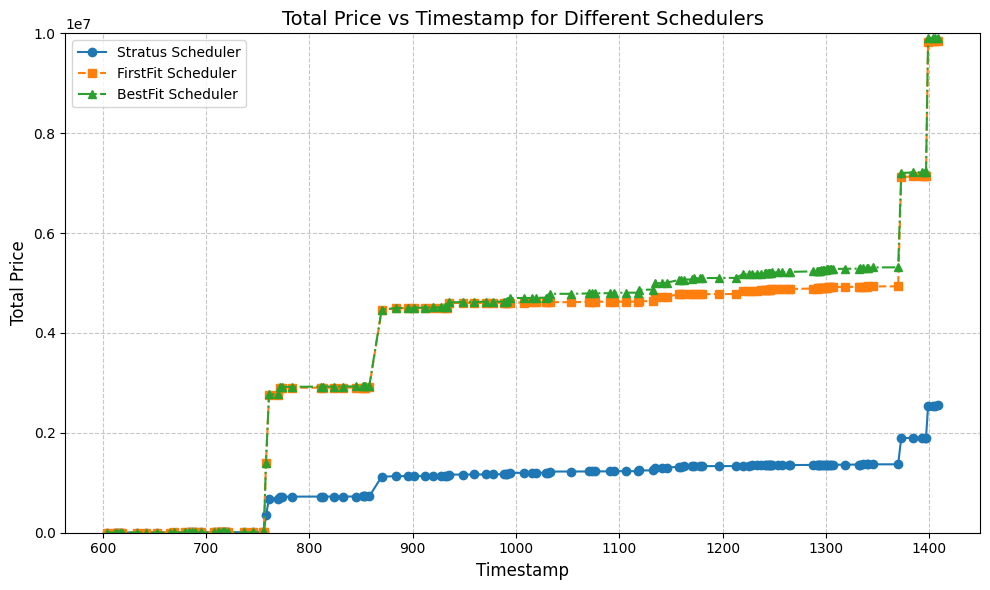

In [183]:
import matplotlib.pyplot as plt

# Plot the total price for each scheduler against the timestamp
plt.figure(figsize=(10, 6))

# Stratus Scheduler price
plt.plot(timestamp_points, stratus_price, label='Stratus Scheduler', linestyle='-', marker='o')

# FirstFit Scheduler price
plt.plot(timestamp_points, firstfit_price, label='FirstFit Scheduler', linestyle='--', marker='s')

# BestFit Scheduler price
plt.plot(timestamp_points, bestfit_price, label='BestFit Scheduler', linestyle='-.', marker='^')

# Adding labels and title
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Total Price', fontsize=12)
plt.title('Total Price vs Timestamp for Different Schedulers', fontsize=14)

# Set y-axis range
plt.ylim(0, 10000000)

# Adding legend
plt.legend()

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

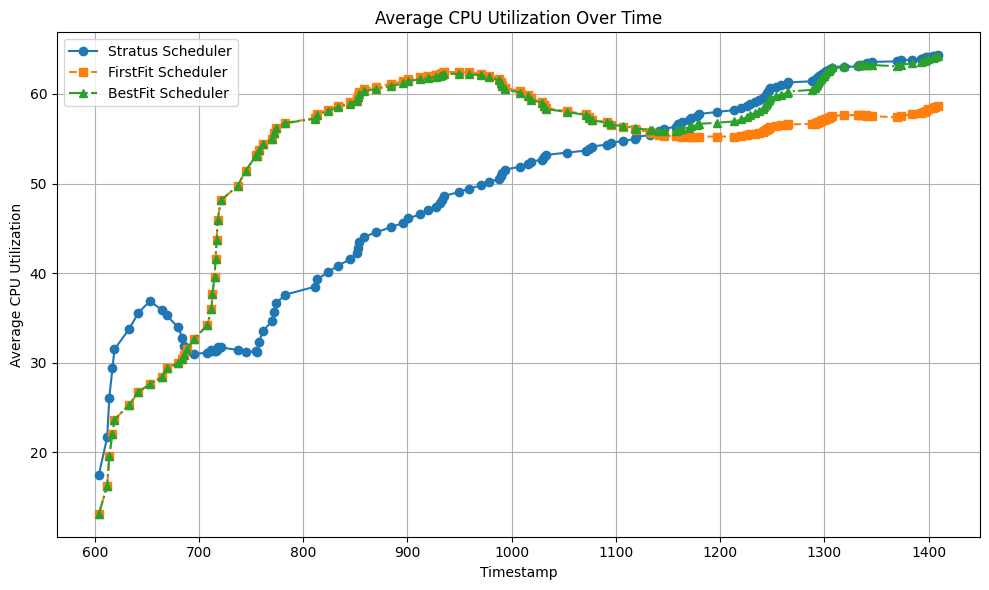

In [184]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate cumulative average utilization for each scheduler
stratus_avg_cpu_utilization = np.cumsum(stratus_cpu_utilization) / np.arange(1, len(stratus_cpu_utilization) + 1)
firstfit_avg_cpu_utilization = np.cumsum(firstfit_cpu_utilization) / np.arange(1, len(firstfit_cpu_utilization) + 1)
bestfit_avg_cpu_utilization = np.cumsum(bestfit_cpu_utilization) / np.arange(1, len(bestfit_cpu_utilization) + 1)

# Plot CPU utilization against timestamp for the three schedulers
plt.figure(figsize=(10, 6))
plt.plot(timestamp_points, stratus_avg_cpu_utilization, label="Stratus Scheduler", linestyle='-', marker='o')
plt.plot(timestamp_points, firstfit_avg_cpu_utilization, label="FirstFit Scheduler", linestyle='--', marker='s')
plt.plot(timestamp_points, bestfit_avg_cpu_utilization, label="BestFit Scheduler", linestyle='-.', marker='^')

plt.title("Average CPU Utilization Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Average CPU Utilization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

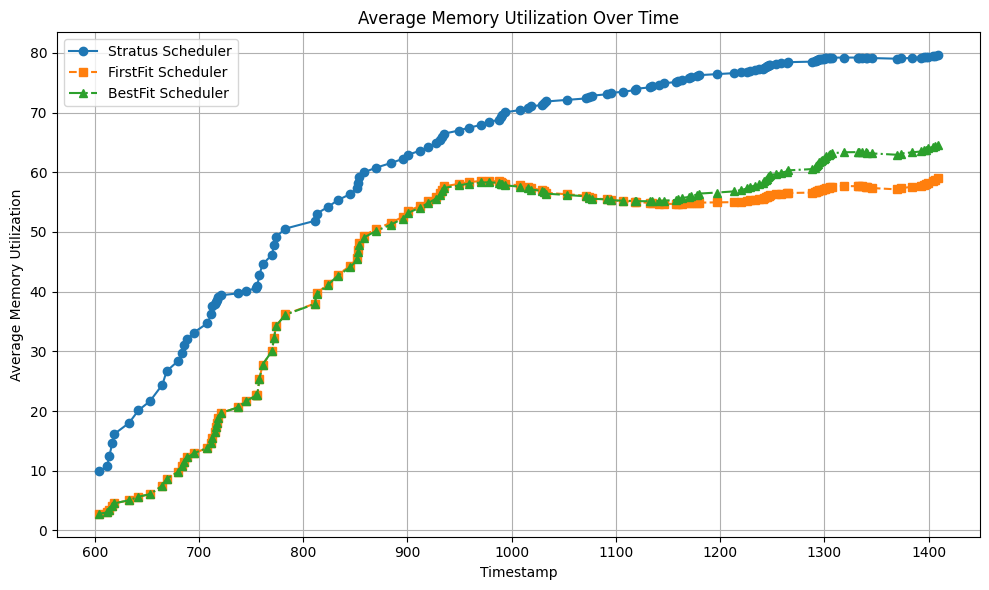

In [185]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate cumulative average utilization for each scheduler
stratus_avg_mem_utilization = np.cumsum(stratus_memory_utilization) / np.arange(1, len(stratus_memory_utilization) + 1)
firstfit_avg_mem_utilization = np.cumsum(firstfit_memory_utilization) / np.arange(1, len(firstfit_memory_utilization) + 1)
bestfit_avg_mem_utilization = np.cumsum(bestfit_memory_utilization) / np.arange(1, len(bestfit_memory_utilization) + 1)

# Plot CPU utilization against timestamp for the three schedulers
plt.figure(figsize=(10, 6))
plt.plot(timestamp_points, stratus_avg_mem_utilization, label="Stratus Scheduler", linestyle='-', marker='o')
plt.plot(timestamp_points, firstfit_avg_mem_utilization, label="FirstFit Scheduler", linestyle='--', marker='s')
plt.plot(timestamp_points, bestfit_avg_mem_utilization, label="BestFit Scheduler", linestyle='-.', marker='^')

plt.title("Average Memory Utilization Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Average Memory Utilization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

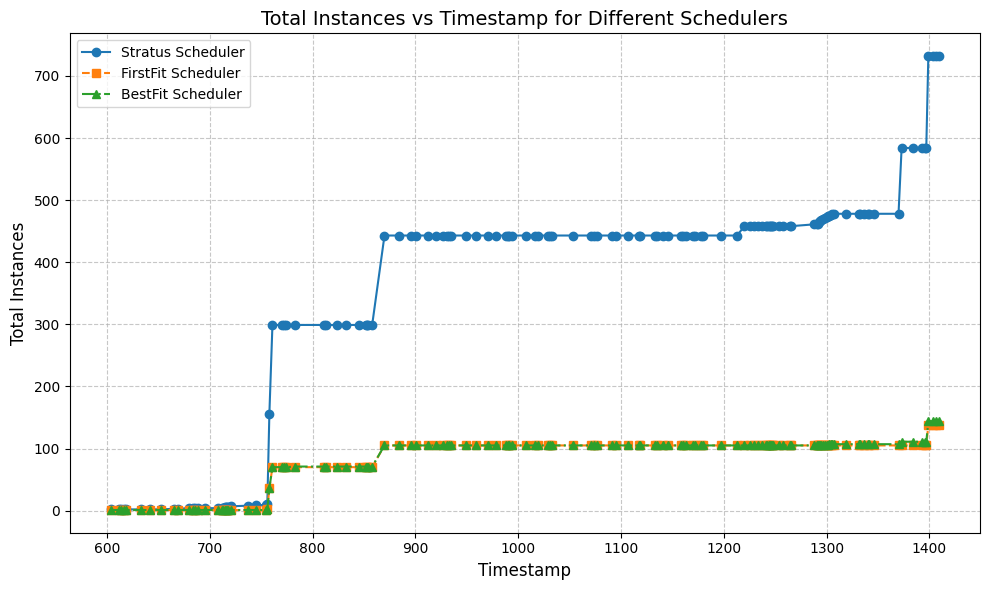

In [187]:
import matplotlib.pyplot as plt

# Plot the total price for each scheduler against the timestamp
plt.figure(figsize=(10, 6))

# Stratus Scheduler price
plt.plot(timestamp_points, stratus_instances, label='Stratus Scheduler', linestyle='-', marker='o')

# FirstFit Scheduler price
plt.plot(timestamp_points, firstfit_instances, label='FirstFit Scheduler', linestyle='--', marker='s')

# BestFit Scheduler price
plt.plot(timestamp_points, bestfit_instances, label='BestFit Scheduler', linestyle='-.', marker='^')

# Adding labels and title
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Total Instances', fontsize=12)
plt.title('Total Instances vs Timestamp for Different Schedulers', fontsize=14)

# Adding legend
plt.legend()

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()